# Week 8: LDA, QDA, and Decision Trees

This week, we will learn how to implement linear discriminant analysis (LDA) and quadratic discriminant analysis (QDA) for classification as well as begin learning about decision trees.

## Lecture 20: Implementing LDA and QDA

Today, we will apply some of the theory from the last class to use linear discriminant analysis (and quadratic discriminant analysis) on some real classification problems. Let's import some libraries first.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

### LDA Class

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

class DA(ClassifierMixin, BaseEstimator):
    def __init__(self, equalCovariances = True, alpha = 1, gamma = 1):
        # if True, LDA
        # if False, QDA
        self.equalCovariances = equalCovariances
        
        # if less than 1, regularized DA (requires QDA)
        self.alpha = alpha
        
        # if less than 1, shrinkage
        self.gamma = gamma
        
    def fit(self, X, Y):
        # find the unique labels
        uniqueY = np.unique(Y)
        
        # find the dimensions
        n = X.shape[0]
        self.d = X.shape[1]
        self.k = uniqueY.shape[0]

        # initialize the variables
        self.prior = np.zeros([self.k, 1])
        self.mu = np.zeros([self.k, 1, self.d])
        
        # compute the covariance matrix
        if self.equalCovariances or self.gamma < 1 or self.alpha < 1:
            mu = np.mean(X, axis = 0)
            Xbar = X - mu
            self.Sig = (1/n) * Xbar.T @ Xbar
            
            # shrinkage
            if self.gamma < 1:
                self.Sig = self.gamma * self.Sig + (1 - self.gamma) * np.diag(self.Sig)
                
            self.invCov = np.linalg.inv(self.Sig)
        
        if not self.equalCovariances:
            self.Sigma = np.zeros([self.k, self.d, self.d])            
        
        for i, y in enumerate(uniqueY):
            # extract a class of datapoints from X
            Xi = X[Y == y]
            
            # compute the size of each class
            ni = Xi.shape[0]
            
            # compute the priors
            self.prior[i] = ni / n
                        
            # compute the feature means within the class
            self.mu[i] = np.mean(Xi, axis = 0)
            
            # compute separate covariances for QDA
            if not self.equalCovariances:
                # compute the centered data
                XiBar = Xi - self.mu[i]
            
                # compute the class sample covariance
                self.Sigma[i] = (1/ni) * XiBar.T @ XiBar
                
                # regularization
                if self.alpha < 1:
                    self.Sigma[i] = self.alpha * self.Sigma[i] + (1 - self.alpha) * self.Sig
                
        
    def predict(self, X):
        n = X.shape[0]
        
        discriminants = np.zeros([n, self.k])
        
        for i, x in enumerate(X):
            x = np.atleast_2d(x).T
            
            for j in range(self.k):
                if not self.equalCovariances:
                    self.invCov = np.linalg.inv(self.Sigma[j])

                discriminants[i][j] = x.T @ self.invCov @ self.mu[j].T - (1/2) * self.mu[j] @ self.invCov @ self.mu[j].T + np.log(self.prior[j])

            
        predictions = np.argmax(discriminants, axis = 1)
        
        return predictions
    
    def score(self, X, y, sample_weight = None):
        return accuracy_score(y, self.predict(X), sample_weight = sample_weight)

### Example: Randomly Generated Points

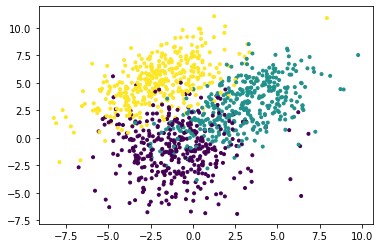

In [18]:
# number of points to generate
numberOfPoints = 500

# generate points from class 0
mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([3, 3])
covariance2 = np.array([[5, 3], [3, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# generate points from class 2
mean3 = np.array([-2, 5])
covariance3 = np.array([[5, 3], [3, 5]])
X3 = np.random.multivariate_normal(mean3, covariance3, numberOfPoints)

# stack the points
X = np.vstack((X1, X2, X3))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1], numberOfPoints * [2]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

#### Using Our DA method...


Classification Report:

               precision    recall  f1-score   support

           0       0.84      0.85      0.84       120
           1       0.86      0.85      0.86       127
           2       0.88      0.88      0.88       128

    accuracy                           0.86       375
   macro avg       0.86      0.86      0.86       375
weighted avg       0.86      0.86      0.86       375


Confusion Matrix:



<AxesSubplot:>

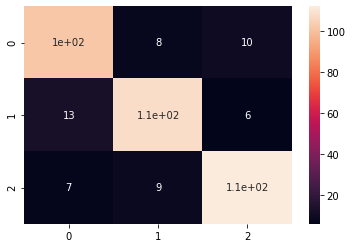

In [19]:
# fit the model to the training data
model = DA()
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Let's try with QDA.


Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.80      0.83       120
           1       0.88      0.86      0.87       127
           2       0.85      0.93      0.89       128

    accuracy                           0.86       375
   macro avg       0.86      0.86      0.86       375
weighted avg       0.86      0.86      0.86       375


Confusion Matrix:



<AxesSubplot:>

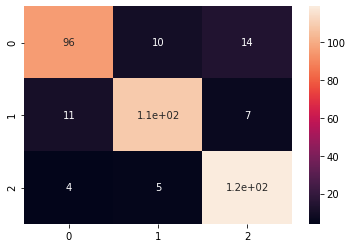

In [20]:
# fit the model to the training data
model = DA(equalCovariances = False)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Mean CV accuracy for parameters 0.1 0.1 is 0.8426666666666666
Mean CV accuracy for parameters 0.1 0.2 is 0.8435555555555556
Mean CV accuracy for parameters 0.1 0.3 is 0.8426666666666668
Mean CV accuracy for parameters 0.1 0.4 is 0.8462222222222222
Mean CV accuracy for parameters 0.1 0.5 is 0.8444444444444444
Mean CV accuracy for parameters 0.1 0.6 is 0.8417777777777777
Mean CV accuracy for parameters 0.1 0.7 is 0.8435555555555554
Mean CV accuracy for parameters 0.1 0.8 is 0.8417777777777777
Mean CV accuracy for parameters 0.1 0.9 is 0.8408888888888889
Mean CV accuracy for parameters 0.1 1.0 is 0.8400000000000001
Mean CV accuracy for parameters 0.2 0.1 is 0.8400000000000001
Mean CV accuracy for parameters 0.2 0.2 is 0.8408888888888889
Mean CV accuracy for parameters 0.2 0.3 is 0.8417777777777777
Mean CV accuracy for parameters 0.2 0.4 is 0.8453333333333333
Mean CV accuracy for parameters 0.2 0.5 is 0.8444444444444444
Mean CV accuracy for parameters 0.2 0.6 is 0.8444444444444444
Mean CV 

<AxesSubplot:>

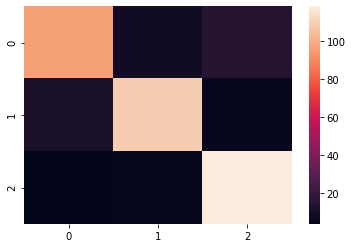

In [21]:
# initialize accuracy and hyperparameter list
bestAccuracy = [0, 0, 0]

# test regularization hyperparameters 0.00, 0.01, ..., 0.19
for i in range(1, 11):
    for j in range(1, 11):
        alpha = i/10
        gamma = j/10

        # build the QDA classifier
        model = DA(False, alpha, gamma)

        # fit the QDA classifier to the training data
        model.fit(trainX, trainY)
        
        # compute the test predictions
        predictedY = model.predict(testX)

        # find the mean cross-validation accuracy
        mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

        # print quality metrics
        print('Mean CV accuracy for parameters', alpha, gamma, 'is', mean_cv_scores)

        # save the hyperparameter reg_param if better than found before
        if mean_cv_scores > bestAccuracy[0]:
            bestAccuracy = [mean_cv_scores, alpha, gamma]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with alpha =', bestAccuracy[1], 'and gamma =', bestAccuracy[2])
        
# build the QDA classifier
model = DA(False, bestAccuracy[1], bestAccuracy[2])

# fit the QDA classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for the best hyperparameters:\n\n', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

#### `scikit-learn` Implementations

Now that we fully see how LDA and QDA work, we will rely on the optimized `scikit-learn` implementations of LDA and QDA.


Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.83      0.82       120
           1       0.88      0.83      0.85       127
           2       0.90      0.91      0.91       128

    accuracy                           0.86       375
   macro avg       0.86      0.86      0.86       375
weighted avg       0.86      0.86      0.86       375


Confusion Matrix:



<AxesSubplot:>

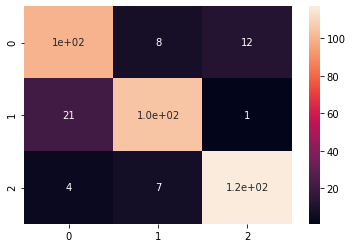

In [7]:
# fit the model to the training data
model = LinearDiscriminantAnalysis()
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Mean CV accuracy for regularization parameter 0.0 is 0.863111111111111
Mean CV accuracy for regularization parameter 0.01 is 0.863111111111111
Mean CV accuracy for regularization parameter 0.02 is 0.863111111111111
Mean CV accuracy for regularization parameter 0.03 is 0.863111111111111
Mean CV accuracy for regularization parameter 0.04 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.05 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.06 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.07 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.08 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.09 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.1 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.11 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.12 is 0.8639999999999999
Mean CV accuracy for regularization parameter 0.13 is 0.8

<AxesSubplot:>

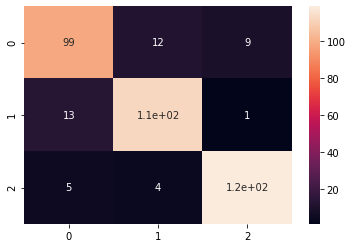

In [8]:
# initialize accuracy and hyperparameter list
bestAccuracy = [0, 0]

# test regularization hyperparameters 0.00, 0.01, ..., 0.20
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for regularization parameter', rp, 'is', mean_cv_scores)
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, rp]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'regularization parameter')
        
# build the QDA classifier
model = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy[1])

# fit the QDA classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Example from scikit-learn: LDA vs QDA

This example is lightly modified from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py).

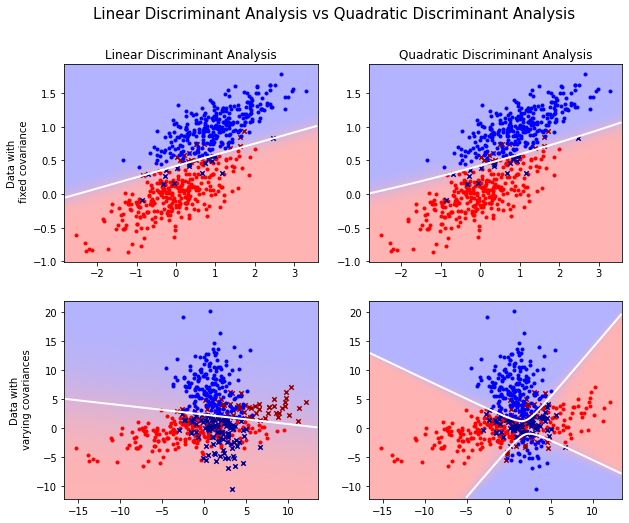

In [9]:
from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

# Generate datasets
def dataset_fixed_cov():
    # Generate 2 Gaussians samples with the same covariance matrix
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C), np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def dataset_cov():
    # Generate 2 Gaussians samples with different covariance matrices
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C), np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x', s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x', s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 100))
    
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes', norm=colors.Normalize(0., 1.), zorder=0, shading='auto')
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    return splot

plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis', y=0.98, fontsize=15)

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis()
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis()
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)

### Example: Breast Cancer


Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.86      0.92        57
           1       0.91      1.00      0.96        86

    accuracy                           0.94       143
   macro avg       0.96      0.93      0.94       143
weighted avg       0.95      0.94      0.94       143


Confusion Matrix:



<AxesSubplot:>

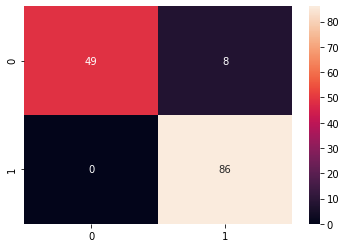

In [10]:
# import the breast cancer dataset
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = DA()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Example: Classifying MNIST Handwritten Digits with LDA and QDA

#### LDA


Training Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5923
           1       0.87      0.96      0.91      6742
           2       0.92      0.82      0.86      5958
           3       0.86      0.85      0.86      6131
           4       0.86      0.90      0.88      5842
           5       0.83      0.82      0.83      5421
           6       0.93      0.92      0.92      5918
           7       0.92      0.84      0.88      6265
           8       0.81      0.80      0.80      5851
           9       0.78      0.86      0.82      5949

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.89      0.97      0.93      1135
         

<AxesSubplot:>

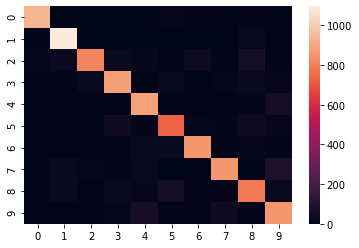

In [11]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = LinearDiscriminantAnalysis()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

#### LDA with Ledoit-Wolf shrinkage


Training Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5923
           1       0.87      0.96      0.91      6742
           2       0.92      0.82      0.87      5958
           3       0.86      0.84      0.85      6131
           4       0.87      0.90      0.88      5842
           5       0.84      0.83      0.83      5421
           6       0.93      0.92      0.93      5918
           7       0.93      0.85      0.89      6265
           8       0.81      0.80      0.81      5851
           9       0.79      0.88      0.83      5949

    accuracy                           0.88     60000
   macro avg       0.88      0.87      0.87     60000
weighted avg       0.88      0.88      0.88     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.89      0.96      0.93      1135
         

<AxesSubplot:>

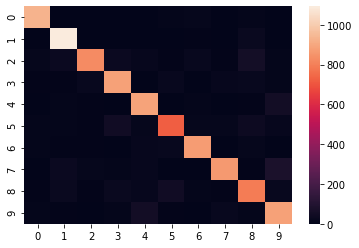

In [12]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

#### QDA

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Training Classification Report:

               precision    recall  f1-score   support

           0       0.40      0.98      0.57      5923
           1       0.85      0.96      0.90      6742
           2       0.96      0.27      0.42      5958
           3       0.72      0.41      0.52      6131
           4       0.98      0.21      0.34      5842
           5       0.97      0.19      0.32      5421
           6       0.74      0.97      0.84      5918
           7       0.94      0.44      0.60      6265
           8       0.50      0.70      0.58      5851
           9       0.50      0.97      0.66      5949

    accuracy                           0.62     60000
   macro avg       0.76      0.61      0.58     60000
weighted avg       0.76      0.62      0.58     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.37      0.96      0.54       980
           1       0.89      0.96      0.92      1135
         

<AxesSubplot:>

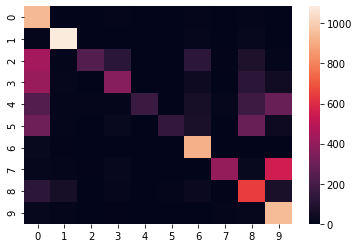

In [13]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = QuadraticDiscriminantAnalysis()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

#### QDA with Regularization

Mean CV accuracy for regularization parameter 0.0 is 0.5734833333333333
Mean CV accuracy for regularization parameter 0.01 is 0.9422333333333335
Mean CV accuracy for regularization parameter 0.02 is 0.9486666666666667
Mean CV accuracy for regularization parameter 0.03 is 0.9512333333333333
Mean CV accuracy for regularization parameter 0.04 is 0.9525166666666667
Mean CV accuracy for regularization parameter 0.05 is 0.95325
Mean CV accuracy for regularization parameter 0.06 is 0.9531333333333333
Mean CV accuracy for regularization parameter 0.07 is 0.95305
Mean CV accuracy for regularization parameter 0.08 is 0.9527833333333333
Mean CV accuracy for regularization parameter 0.09 is 0.9523833333333332
Mean CV accuracy for regularization parameter 0.1 is 0.9519833333333333
Mean CV accuracy for regularization parameter 0.11 is 0.9513166666666667
Mean CV accuracy for regularization parameter 0.12 is 0.9509000000000001
Mean CV accuracy for regularization parameter 0.13 is 0.9502833333333334
Me

<AxesSubplot:>

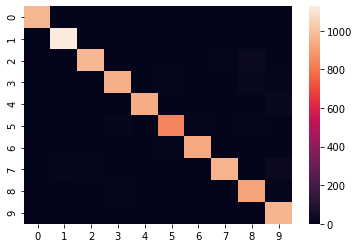

In [14]:
# collinearity warnings keep popping up, so we suppress them
import warnings
warnings.filterwarnings('ignore')

# import MNIST data
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# initialize accuracy and hyperparameter list
bestAccuracy = [0, 0]

# test regularization hyperparameters 0.00, 0.01, ..., 0.19
for i in range(20):
    rp = i/100
    
    # build the QDA classifier
    model = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for regularization parameter', rp, 'is', mean_cv_scores)
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, rp]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'regularization parameter')
        
# build the QDA classifier
model = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy[1])

# fit the QDA classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'reg_param:\n\n', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))